# 02 — Feature Engineering

Computes technical indicators, fundamental features, and sentiment scores.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_loader import fetch_multiple_stocks
from src.feature_engineering import engineer_features, create_feature_matrix
from src.sentiment import compute_batch_sentiment

pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')
%matplotlib inline

## 1. Load Data

In [2]:
SELECTED_TICKERS = ["AAPL","MSFT","GOOGL","AMZN","NVDA","META","TSLA","JPM","V","MA","GS","JNJ","UNH","LLY","MRK","ABBV","XOM","CVX","PG","KO","PEP","WMT","HD","CRM","AMD","NFLX","DIS","INTC","BA","GE"]
stock_data = fetch_multiple_stocks(SELECTED_TICKERS, period="2y")
fundamentals_df = pd.read_parquet("../data/raw/fundamentals.parquet")
print(f"Loaded {len(stock_data)} stocks and fundamentals for {len(fundamentals_df)} stocks")

Fetching stock data:   0%|          | 0/30 [00:00<?, ?it/s]

Fetching stock data:   7%|▋         | 2/30 [00:00<00:01, 19.91it/s]

Fetching stock data: 100%|██████████| 30/30 [00:00<00:00, 224.62it/s]

Successfully loaded data for 30/30 tickers
Loaded 30 stocks and fundamentals for 30 stocks


## 2. Engineer Technical Features (Single Stock Example)

In [3]:
sample_ticker = "AAPL"
sample_features = engineer_features(stock_data[sample_ticker])
print(f"Features for {sample_ticker}: {sample_features.shape}")
print(f"\nFeature columns ({len(sample_features.columns)}):")
print(list(sample_features.columns))
sample_features.tail()

Features for AAPL: (502, 38)

Feature columns (38):
['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'Price_vs_SMA_20', 'SMA_50', 'Price_vs_SMA_50', 'SMA_200', 'Price_vs_SMA_200', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Bandwidth', 'BB_PctB', 'ATR', 'ATR_Pct', 'OBV', 'OBV_SMA', 'Return_1d', 'Return_5d', 'Return_21d', 'Volatility_5d', 'Volatility_21d', 'Volatility_63d', 'Momentum_5d', 'Momentum_10d', 'Momentum_21d', 'Momentum_63d', 'Volume_SMA_20', 'Volume_Ratio', 'Daily_Range', 'Gap']


,Open,High,Low,Close,Volume,SMA_20,Price_vs_SMA_20,SMA_50,Price_vs_SMA_50,SMA_200,Price_vs_SMA_200,RSI,MACD,MACD_Signal,MACD_Hist,BB_Upper,BB_Middle,BB_Lower,BB_Bandwidth,BB_PctB,ATR,ATR_Pct,OBV,OBV_SMA,Return_1d,Return_5d,Return_21d,Volatility_5d,Volatility_21d,Volatility_63d,Momentum_5d,Momentum_10d,Momentum_21d,Momentum_63d,Volume_SMA_20,Volume_Ratio,Daily_Range,Gap
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2026-02-19 00:00:00-05:00,262.600006,264.480011,260.049988,260.579987,30845300,264.072562,-0.013226,266.169602,-0.021000,240.404276,0.083924,52.114367,0.196570,0.871918,-0.675348,283.036407,264.072562,245.108716,0.143626,0.407915,7.376216,0.028307,2255407000,2.233469e+09,-0.014261,-0.054156,0.057251,0.479620,0.313469,0.220431,-0.054156,-0.056661,0.057251,-0.024812,55605050.00,0.554721,0.017001,-0.006620
2026-02-20 00:00:00-05:00,258.970001,264.750000,258.160004,264.579987,42070500,264.895669,-0.001192,265.908597,-0.004996,240.737041,0.099041,54.246835,0.142509,0.726037,-0.583527,282.309425,264.895669,247.481913,0.131476,0.490936,7.153294,0.027036,2297477500,2.244436e+09,0.015350,0.010889,0.069362,0.349058,0.316453,0.222644,0.010889,-0.040167,0.069362,-0.009768,55723160.00,0.754991,0.024907,-0.006178
2026-02-23 00:00:00-05:00,263.489990,269.429993,263.380005,266.179993,37308200,265.814262,0.001376,265.693780,0.001830,241.079698,0.104116,46.686194,0.226166,0.626062,-0.399897,281.259743,265.814262,250.368782,0.116213,0.511839,6.780475,0.025473,2334785700,2.259353e+09,0.006047,0.040660,0.072797,0.269421,0.316578,0.222819,0.040660,-0.042036,0.072797,-0.007935,55504120.00,0.672170,0.022729,-0.004120
2026-02-24 00:00:00-05:00,267.859985,274.890015,267.709991,272.140015,46960000,266.662701,0.020540,265.566193,0.024754,241.463407,0.127045,52.450670,0.764574,0.653765,0.110809,281.498772,266.662701,251.826631,0.111272,0.684594,7.097903,0.026082,2381745700,2.273819e+09,0.022391,0.031302,0.098188,0.222254,0.322604,0.226563,0.031302,-0.009031,0.098188,0.023079,55053660.00,0.852986,0.026384,0.006311
2026-02-25 00:00:00-05:00,271.679993,274.079987,271.049988,273.440002,8025261,267.433275,0.022461,265.479591,0.029985,241.847442,0.130630,47.401192,1.281394,0.779291,0.502103,281.979210,267.433275,252.887340,0.108782,0.706474,6.638536,0.024278,2389770961,2.286205e+09,0.004777,0.034386,0.071594,0.219449,0.309511,0.223363,0.034386,-0.000877,0.071594,0.008125,52972508.05,0.151499,0.011081,-0.001690


## 3. Visualize Technical Indicators

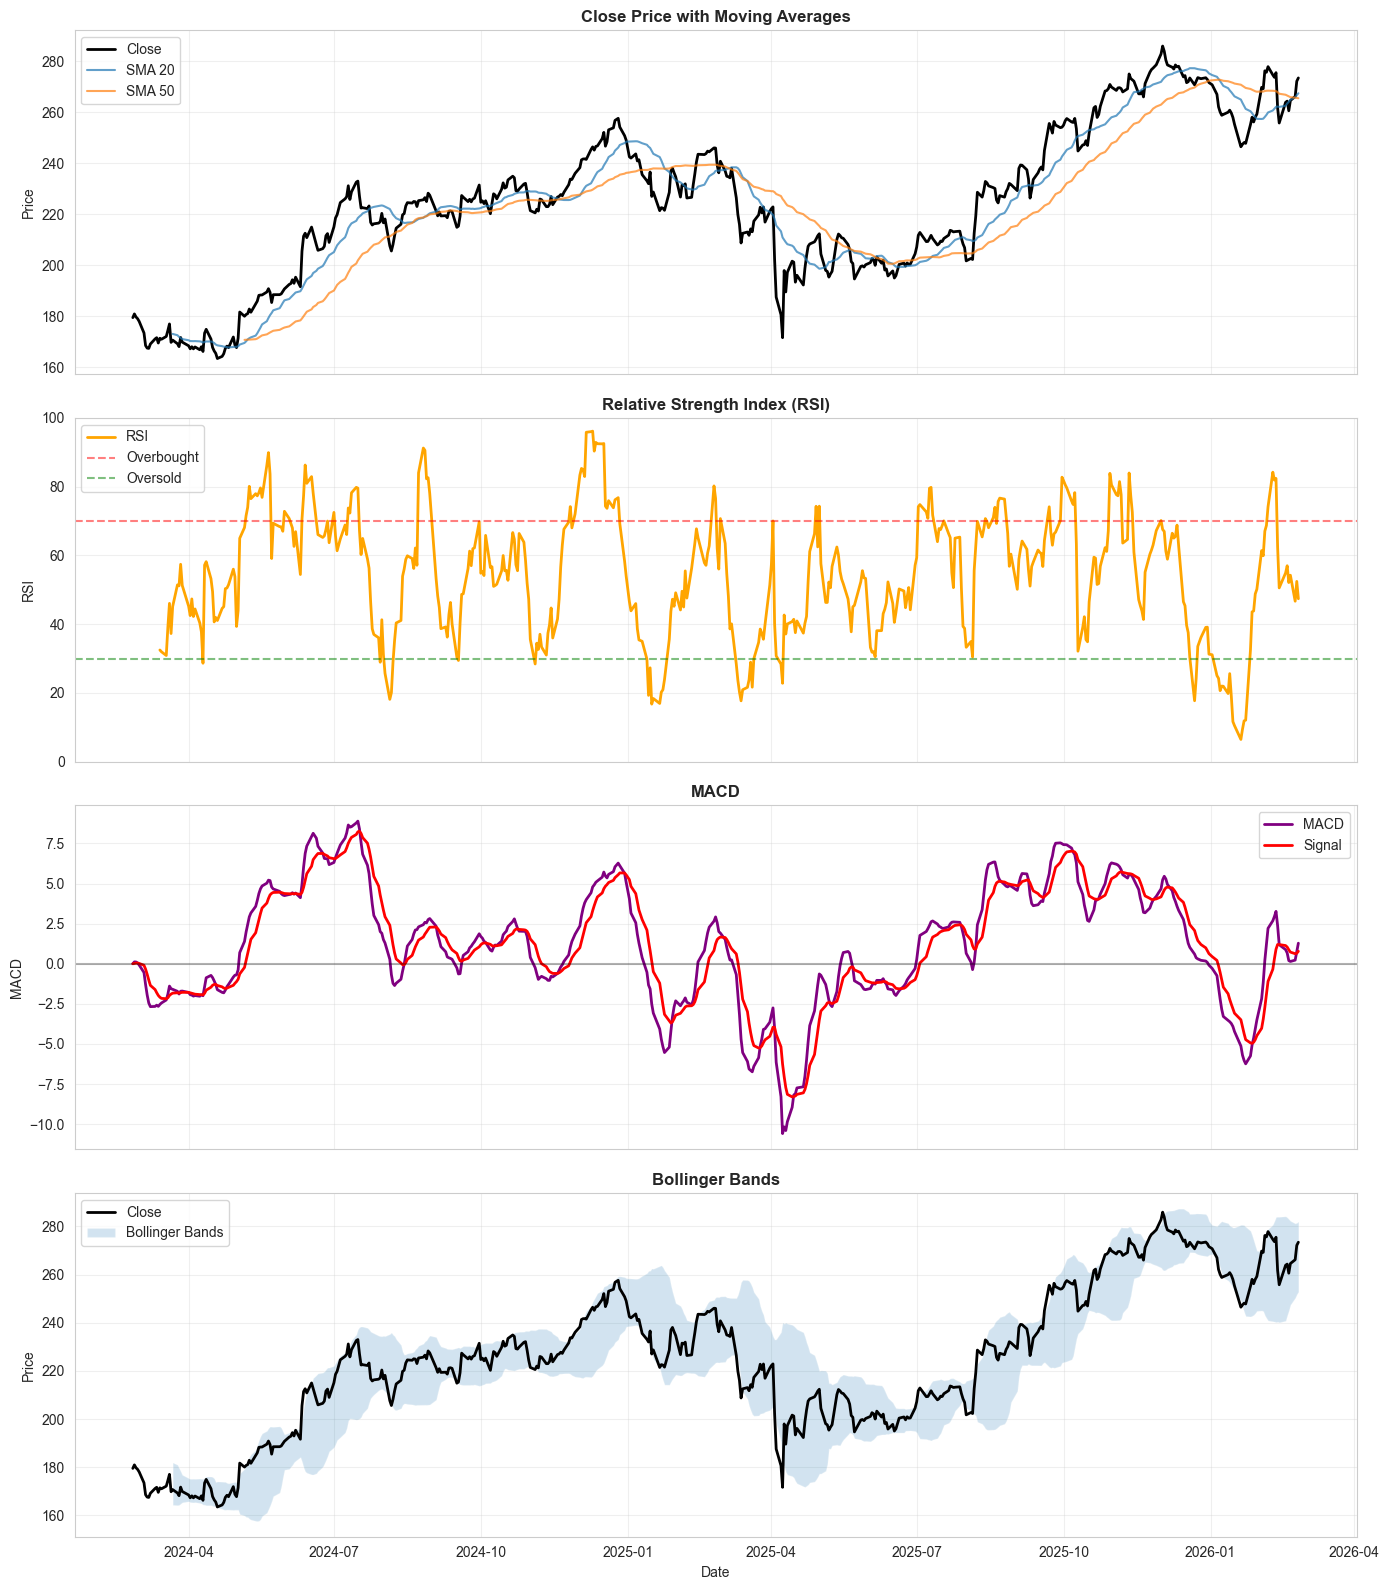

In [4]:
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# Close + SMAs
axes[0].plot(sample_features.index, sample_features['Close'], label='Close', linewidth=2, color='black')
if 'SMA_20' in sample_features.columns:
    axes[0].plot(sample_features.index, sample_features['SMA_20'], label='SMA 20', linewidth=1.5, alpha=0.7)
if 'SMA_50' in sample_features.columns:
    axes[0].plot(sample_features.index, sample_features['SMA_50'], label='SMA 50', linewidth=1.5, alpha=0.7)
axes[0].set_title('Close Price with Moving Averages', fontweight='bold')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(alpha=0.3)

# RSI
if 'RSI' in sample_features.columns:
    axes[1].plot(sample_features.index, sample_features['RSI'], label='RSI', linewidth=2, color='orange')
    axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought')
    axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold')
    axes[1].set_title('Relative Strength Index (RSI)', fontweight='bold')
    axes[1].set_ylabel('RSI')
    axes[1].set_ylim([0, 100])
    axes[1].legend()
    axes[1].grid(alpha=0.3)

# MACD
if 'MACD' in sample_features.columns:
    axes[2].plot(sample_features.index, sample_features['MACD'], label='MACD', linewidth=2, color='purple')
    if 'MACD_Signal' in sample_features.columns:
        axes[2].plot(sample_features.index, sample_features['MACD_Signal'], label='Signal', linewidth=2, color='red')
    axes[2].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[2].set_title('MACD', fontweight='bold')
    axes[2].set_ylabel('MACD')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

# Bollinger Bands
if 'BB_Upper' in sample_features.columns and 'BB_Lower' in sample_features.columns:
    axes[3].plot(sample_features.index, sample_features['Close'], label='Close', linewidth=2, color='black')
    axes[3].fill_between(sample_features.index, sample_features['BB_Upper'], sample_features['BB_Lower'], alpha=0.2, label='Bollinger Bands')
    axes[3].set_title('Bollinger Bands', fontweight='bold')
    axes[3].set_ylabel('Price')
    axes[3].set_xlabel('Date')
    axes[3].legend()
    axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../figures/02_technical_indicators.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Create Cross-Sectional Feature Matrix

In [5]:
feature_matrix = create_feature_matrix(stock_data)
print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Stocks: {list(feature_matrix.index)}")
print(f"\nFeature stats:")
feature_matrix.describe().round(2)

Feature matrix shape: (30, 38)
Stocks: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'TSLA', 'JPM', 'V', 'MA', 'GS', 'JNJ', 'UNH', 'LLY', 'MRK', 'ABBV', 'XOM', 'CVX', 'PG', 'KO', 'PEP', 'WMT', 'HD', 'CRM', 'AMD', 'NFLX', 'DIS', 'INTC', 'BA', 'GE']

Feature stats:


,Open,High,Low,Close,Volume,SMA_20,Price_vs_SMA_20,SMA_50,Price_vs_SMA_50,SMA_200,Price_vs_SMA_200,RSI,MACD,MACD_Signal,MACD_Hist,BB_Upper,BB_Middle,BB_Lower,BB_Bandwidth,BB_PctB,ATR,ATR_Pct,OBV,OBV_SMA,Return_1d,Return_5d,Return_21d,Volatility_5d,Volatility_21d,Volatility_63d,Momentum_5d,Momentum_10d,Momentum_21d,Momentum_63d,Volume_SMA_20,Volume_Ratio,Daily_Range,Gap
count,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,3.000000e+01,3.000000e+01,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00,3.000000e+01,30.00,30.00,30.00
mean,294.56,297.98,292.49,295.18,7464825.87,296.78,0.00,299.31,0.00,279.91,0.08,49.86,-1.62,-1.34,-0.28,316.27,296.78,277.29,0.14,0.50,9.05,0.03,6.960903e+08,6.917328e+08,0.00,0.01,-0.00,0.31,0.36,0.31,0.01,-0.01,-0.00,0.07,2.794999e+07,0.22,0.02,0.00
std,226.86,229.85,226.15,227.81,12353790.35,230.52,0.03,234.41,0.08,208.40,0.17,12.79,6.03,6.07,1.39,241.07,230.52,220.35,0.07,0.22,8.43,0.01,1.324755e+09,1.261601e+09,0.02,0.03,0.10,0.14,0.16,0.12,0.03,0.04,0.10,0.14,3.499701e+07,0.10,0.01,0.01
min,46.05,46.62,45.51,45.88,423013.00,47.22,-0.04,43.88,-0.17,32.11,-0.26,28.37,-16.60,-17.47,-3.09,51.15,47.22,43.28,0.06,0.07,1.37,0.02,-1.867701e+08,-1.743817e+08,-0.03,-0.04,-0.20,0.09,0.15,0.16,-0.04,-0.06,-0.20,-0.21,2.308821e+06,0.13,0.01,-0.01
25%,165.56,166.01,163.09,164.10,1327910.25,159.34,-0.03,150.11,-0.05,144.81,-0.06,40.73,-5.51,-4.66,-1.01,169.65,159.34,149.03,0.10,0.34,3.69,0.02,2.399508e+07,2.983336e+07,-0.01,-0.02,-0.05,0.21,0.24,0.25,-0.02,-0.03,-0.05,-0.02,8.563397e+06,0.15,0.01,-0.00
50%,231.91,233.21,228.82,230.42,2199223.00,230.95,-0.00,227.64,-0.01,221.17,0.11,49.35,-0.87,0.18,-0.13,250.80,230.95,220.78,0.12,0.47,7.30,0.03,2.176149e+08,1.968652e+08,-0.00,0.01,-0.02,0.30,0.32,0.27,0.01,-0.00,-0.02,0.07,1.338008e+07,0.19,0.02,0.00
75%,337.21,339.77,331.41,333.78,7774520.75,322.18,0.02,330.74,0.08,335.06,0.20,57.68,2.05,3.48,0.54,349.49,322.18,303.88,0.17,0.69,10.21,0.03,6.143901e+08,7.202108e+08,0.01,0.02,0.09,0.38,0.41,0.33,0.02,0.02,0.09,0.19,4.089243e+07,0.27,0.02,0.01
max,1036.58,1053.62,1033.52,1035.92,61701133.00,1034.36,0.07,1052.07,0.11,868.83,0.43,74.55,8.54,7.47,3.08,1078.89,1034.36,989.84,0.35,0.86,38.88,0.05,6.405971e+09,5.995945e+09,0.05,0.06,0.15,0.70,0.83,0.75,0.06,0.08,0.15,0.33,1.691671e+08,0.55,0.05,0.02


## 5. Sentiment Analysis

Note: Sentiment requires API access. If unavailable, we use zero-filled placeholders.

In [6]:
try:
    sentiment_df = compute_batch_sentiment(list(stock_data.keys())[:5], days_back=30)
    print(f"Sentiment computed for {len(sentiment_df)} stocks")
    print(sentiment_df)
except Exception as e:
    print(f"Sentiment computation skipped: {e}")
    sentiment_df = pd.DataFrame(index=feature_matrix.index, columns=["compound_mean","compound_std","positive_ratio","negative_ratio","num_articles"]).fillna(0.0)
    print("Using placeholder sentiment data")

Computing sentiment:   0%|          | 0/5 [00:00<?, ?it/s]

Computing sentiment:  20%|██        | 1/5 [00:00<00:00,  5.30it/s]

Computing sentiment:  40%|████      | 2/5 [00:00<00:00,  6.82it/s]

Computing sentiment:  60%|██████    | 3/5 [00:00<00:00,  7.30it/s]

Computing sentiment:  80%|████████  | 4/5 [00:00<00:00,  6.59it/s]

Computing sentiment: 100%|██████████| 5/5 [00:00<00:00,  5.92it/s]

Computing sentiment: 100%|██████████| 5/5 [00:00<00:00,  6.20it/s]

Sentiment computed for 5 stocks
        compound_mean  compound_std  positive_ratio  negative_ratio  \
ticker                                                                
AAPL         0.099189      0.372959        0.500000        0.321429   
MSFT        -0.106921      0.323501        0.178571        0.464286   
GOOGL       -0.117421      0.358537        0.250000        0.535714   
AMZN        -0.045018      0.378108        0.285714        0.500000   
NVDA         0.007479      0.274153        0.250000        0.250000   

        num_articles  
ticker                
AAPL              28  
MSFT              28  
GOOGL             28  
AMZN              28  
NVDA              28  


## 6. Combine All Features

In [7]:
# Merge feature_matrix with fundamentals (numeric only)
numeric_fundamentals = fundamentals_df.select_dtypes(include=[np.number])
# Use reindex to align fundamentals and sentiment to feature_matrix index, then concat
combined_features = feature_matrix.copy()
combined_features = combined_features.join(numeric_fundamentals.reindex(feature_matrix.index), how='left')
combined_features = combined_features.join(sentiment_df.reindex(feature_matrix.index), how='left', rsuffix='_sent')
combined_features = combined_features.ffill().fillna(0)
print(f"Combined feature matrix shape: {combined_features.shape}")
combined_features.head()

Combined feature matrix shape: (30, 54)


,Open,High,Low,Close,Volume,SMA_20,Price_vs_SMA_20,SMA_50,Price_vs_SMA_50,SMA_200,Price_vs_SMA_200,RSI,MACD,MACD_Signal,MACD_Hist,BB_Upper,BB_Middle,BB_Lower,BB_Bandwidth,BB_PctB,ATR,ATR_Pct,OBV,OBV_SMA,Return_1d,Return_5d,Return_21d,Volatility_5d,Volatility_21d,Volatility_63d,Momentum_5d,Momentum_10d,Momentum_21d,Momentum_63d,Volume_SMA_20,Volume_Ratio,Daily_Range,Gap,market_cap,pe_ratio,forward_pe,beta,dividend_yield,52_week_high,52_week_low,avg_volume,profit_margin,revenue_growth,earnings_growth,compound_mean,compound_std,positive_ratio,negative_ratio,num_articles
AAPL,271.679993,274.079987,271.049988,273.440002,8025261.0,267.433275,0.022461,265.479591,0.029985,241.847442,0.130630,47.401192,1.281394,0.779291,0.502103,281.979210,267.433275,252.887340,0.108782,0.706474,6.638536,0.024278,2.389771e+09,2.286205e+09,0.004777,0.034386,0.071594,0.219449,0.309511,0.223363,0.034386,-0.000877,0.071594,0.008125,5.297251e+07,0.151499,0.011081,-0.001690,4019882557440,34.664130,29.411228,1.107,0.38,288.62,169.21,48279330,0.27037,0.157,0.183,0.099189,0.372959,0.500000,0.321429,28.0
MSFT,390.237488,400.089996,390.200012,399.880005,13342882.0,408.736789,-0.021669,447.585294,-0.106584,484.208878,-0.174158,42.526135,-16.602852,-17.465711,0.862860,450.854189,408.736789,366.619389,0.206086,0.394856,10.375890,0.025948,1.415958e+07,1.477505e+08,0.027969,0.002985,-0.147757,0.351368,0.462852,0.316265,0.002985,-0.030192,-0.147757,-0.151079,4.542097e+07,0.293760,0.024732,0.003181,2973498343424,25.020239,21.224525,1.084,0.94,555.45,344.79,31280636,0.39044,0.167,0.598,-0.106921,0.323501,0.178571,0.464286,28.0
GOOGL,311.994995,313.640015,309.630005,310.315002,7022300.0,320.363748,-0.031367,319.899300,-0.029960,247.853916,0.252008,28.367461,-4.495265,-3.352908,-1.142357,348.506474,320.363748,292.221023,0.175692,0.321468,9.747857,0.031413,1.694027e+09,1.874107e+09,-0.001882,0.023028,-0.068850,0.319971,0.232367,0.251048,0.023028,-0.025943,-0.068850,0.036234,4.016148e+07,0.174852,0.012922,0.003522,3752512454656,28.669308,23.128235,1.086,0.27,349.00,140.53,36532068,0.32810,0.180,0.311,-0.117421,0.358537,0.250000,0.535714,28.0
AMZN,210.460007,211.589996,209.589493,210.554993,9106977.0,216.753250,-0.028596,227.205500,-0.073284,224.264775,-0.061132,29.840946,-7.265889,-7.496922,0.231032,249.437910,216.753250,184.068590,0.301584,0.405181,7.572144,0.035963,6.264639e+08,7.700281e+08,0.009566,0.028151,-0.116874,0.294122,0.339770,0.276230,0.028151,0.017370,-0.116874,-0.045924,6.302371e+07,0.144501,0.009501,0.009110,2260967358464,29.374895,22.661888,1.385,0.27,258.60,161.38,46740750,0.10834,0.136,0.050,-0.045018,0.378108,0.285714,0.500000,28.0
NVDA,194.470001,196.559998,193.800003,195.659897,61701133.0,187.084995,0.045834,185.407599,0.055296,174.334075,0.122327,74.548298,1.884083,0.866593,1.017490,199.150318,187.084995,175.019672,0.128982,0.855353,6.263572,0.032013,6.405971e+09,5.995945e+09,0.014570,0.040855,0.049284,0.087591,0.386331,0.321975,0.040855,0.037763,0.049284,0.093866,1.691671e+08,0.364735,0.014106,0.008400,4763977515008,48.553350,24.901943,2.314,0.02,212.19,86.62,171328373,0.53007,0.625,0.667,0.007479,0.274153,0.250000,0.250000,28.0


## 7. Feature Correlation Analysis

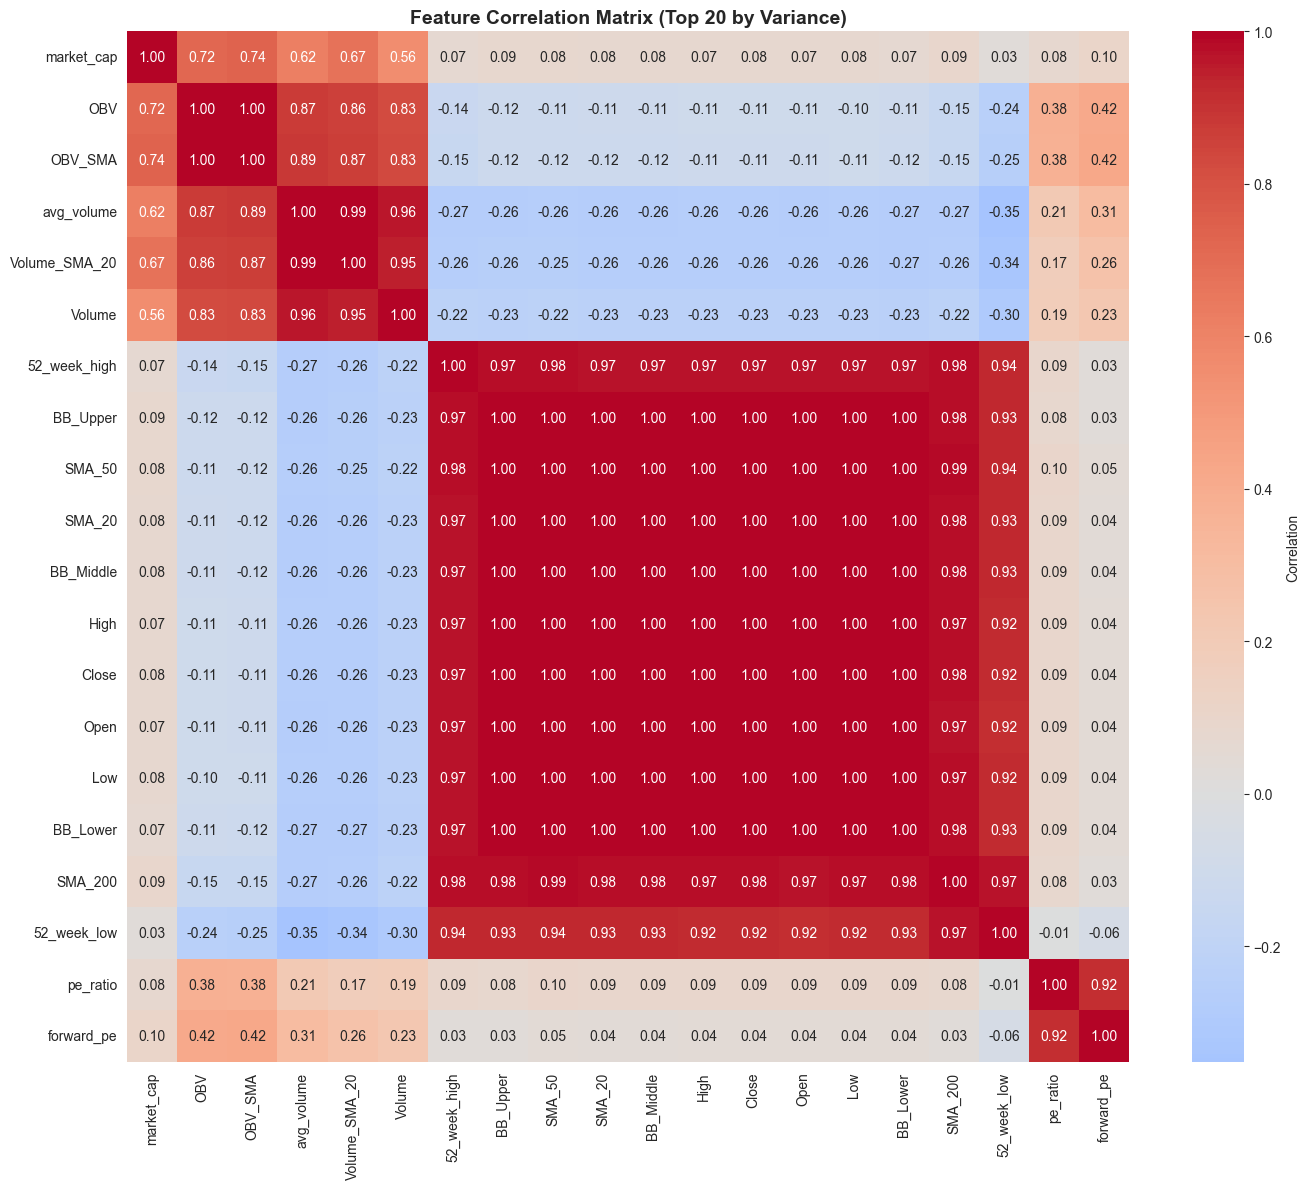

In [8]:
# Select top 20 features by variance
top_20_features = combined_features.var().nlargest(20).index
corr_matrix = combined_features[top_20_features].corr()

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt='.2f', ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Feature Correlation Matrix (Top 20 by Variance)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../figures/02_correlation.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Save Engineered Features

In [9]:
os.makedirs("../data/processed", exist_ok=True)
feature_matrix.to_parquet("../data/processed/feature_matrix.parquet")
numeric_fundamentals.to_parquet("../data/processed/fundamentals_clean.parquet")
sentiment_df.to_parquet("../data/processed/sentiment.parquet")
print(f"Saved feature_matrix: {feature_matrix.shape}")
print(f"Saved fundamentals_clean: {numeric_fundamentals.shape}")
print(f"Saved sentiment: {sentiment_df.shape}")

Saved feature_matrix: (30, 38)
Saved fundamentals_clean: (30, 11)
Saved sentiment: (5, 5)
